# ⬡ ScholarSynth | Advanced Retrieval Techniques
**Search. Synthesize. Succeed.**

### Retrieval Strategies
- **BM25 Implementation** - Keyword-based sparse retrieval
- **Semantic Search** - Dense vector similarity search
- **Multi-Query Retrieval** - Multiple search strategies
- **Parent-Document Retrieval** - Context preservation
- **Ensemble Retrieval** - Combining multiple methods
- **Performance Comparison** - Method evaluation and visualization



In [1]:
# Cell 1: Environment Setup and Advanced Retrieval Imports
import os
import sys
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Tuple
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Core AI/ML imports
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Advanced retrieval imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import arxiv
from langchain_community.tools.tavily_search import TavilySearchResults

# Data processing
import json
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize components
llm = ChatOpenAI(model="gpt-4", temperature=0.1)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
tavily_tool = TavilySearchResults(max_results=3)

print("✅ Advanced retrieval environment ready! (LLM, embeddings, Tavily initialized)")


✅ Advanced retrieval environment ready! (LLM, embeddings, Tavily initialized)


/var/folders/7f/yj7mwjbd2kdg8fnh6p0k8y4w0000gp/T/ipykernel_22557/2496509022.py:35: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)


In [2]:
# Cell 2: Data Collection and Preparation
def collect_research_data(query: str, max_papers: int = 5) -> List[Dict[str, Any]]:
    """
    Collect research data from ArXiv and Tavily for advanced retrieval testing.
    """
    print(f"🔍 Collecting data: '{query}'")
    
    all_documents = []
    
    # Collect from ArXiv
    try:
        search = arxiv.Search(
            query=query,
            max_results=max_papers,
            sort_by=arxiv.SortCriterion.Relevance
        )
        
        for result in search.results():
            doc = {
                'title': result.title,
                'content': result.summary,
                'authors': [author.name for author in result.authors],
                'published': result.published.strftime('%Y-%m-%d'),
                'arxiv_id': result.entry_id.split('/')[-1],
                'categories': result.categories,
                'source': 'arxiv',
                'url': result.entry_id
            }
            all_documents.append(doc)
        
        arxiv_count = len([d for d in all_documents if d['source'] == 'arxiv'])
        print(f"   📚 ArXiv: {arxiv_count} papers")
        
    except Exception as e:
        print(f"   ❌ ArXiv error: {e}")
    
    # Collect from Tavily
    try:
        web_results = tavily_tool.invoke(query)
        
        for result in web_results:
            doc = {
                'title': result.get('title', 'Web Research Result'),
                'content': result.get('content', 'No content available'),
                'authors': ['Web Source'],
                'published': 'Recent',
                'arxiv_id': 'web',
                'categories': ['web'],
                'source': 'tavily',
                'url': result.get('url', 'No URL')
            }
            all_documents.append(doc)
        
        tavily_count = len([d for d in all_documents if d['source'] == 'tavily'])
        print(f"   🌐 Tavily: {tavily_count} web results")
        
    except Exception as e:
        print(f"   ❌ Tavily error: {e}")
    
    print(f"   ✅ Total: {len(all_documents)} documents")
    return all_documents

def prepare_documents_for_retrieval(documents: List[Dict[str, Any]]) -> List[Document]:
    """
    Prepare documents for advanced retrieval methods.
    """
    # Create LangChain Documents
    langchain_docs = []
    for i, doc in enumerate(documents):
        # Create metadata
        metadata = {
            'title': doc['title'],
            'authors': doc['authors'],
            'published': doc['published'],
            'source': doc['source'],
            'arxiv_id': doc.get('arxiv_id', 'unknown'),
            'categories': doc.get('categories', []),
            'url': doc.get('url', ''),
            'doc_id': i
        }
        
        # Create LangChain Document
        langchain_doc = Document(
            page_content=doc['content'],
            metadata=metadata
        )
        langchain_docs.append(langchain_doc)
    
    return langchain_docs

# Test data collection
test_query = "transformer architecture attention mechanism"
research_docs = collect_research_data(test_query, max_papers=3)
prepared_docs = prepare_documents_for_retrieval(research_docs)

print(f"\n📊 Prepared {len(prepared_docs)} documents for retrieval testing")


🔍 Collecting data: 'transformer architecture attention mechanism'
   📚 ArXiv: 3 papers
   🌐 Tavily: 3 web results
   ✅ Total: 6 documents

📊 Prepared 6 documents for retrieval testing


In [3]:
# Cell 3: BM25 Implementation for Keyword-Based Search
class BM25Retriever:
    """
    BM25 (Best Matching 25) implementation for keyword-based sparse retrieval.
    """
    
    def __init__(self, k1: float = 1.2, b: float = 0.75):
        self.k1 = k1
        self.b = b
        self.documents = []
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.avgdl = 0
        
    def fit(self, documents: List[Document]):
        """Fit BM25 on the document collection."""
        self.documents = [doc.page_content for doc in documents]
        self.doc_len = [len(doc.split()) for doc in self.documents]
        self.avgdl = sum(self.doc_len) / len(self.doc_len)
        
        # Calculate document frequencies
        self.doc_freqs = []
        for doc in self.documents:
            doc_freq = defaultdict(int)
            for word in doc.lower().split():
                doc_freq[word] += 1
            self.doc_freqs.append(doc_freq)
        
        # Calculate IDF scores
        df = defaultdict(int)
        for doc_freq in self.doc_freqs:
            for word in doc_freq:
                df[word] += 1
        
        for word, freq in df.items():
            self.idf[word] = np.log((len(self.documents) - freq + 0.5) / (freq + 0.5))
    
    def score(self, query: str, doc_idx: int) -> float:
        """Calculate BM25 score for a query and document."""
        score = 0
        query_words = query.lower().split()
        
        for word in query_words:
            if word in self.doc_freqs[doc_idx]:
                tf = self.doc_freqs[doc_idx][word]
                idf = self.idf.get(word, 0)
                
                # BM25 formula
                score += idf * (tf * (self.k1 + 1)) / (tf + self.k1 * (1 - self.b + self.b * (self.doc_len[doc_idx] / self.avgdl)))
        
        return score
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Tuple[Document, float]]:
        """Retrieve top-k documents for a query."""
        scores = []
        
        for i in range(len(self.documents)):
            score = self.score(query, i)
            scores.append((i, score))
        
        # Sort by score (descending)
        scores.sort(key=lambda x: x[1], reverse=True)
        
        # Return top-k results
        results = []
        for i, (doc_idx, score) in enumerate(scores[:top_k]):
            if score > 0:  # Only return documents with positive scores
                results.append((self.documents[doc_idx], score))
        
        return results

# Test BM25 implementation
print("🧪 Testing BM25 Implementation")

# Initialize BM25
bm25_retriever = BM25Retriever()
bm25_retriever.fit(prepared_docs)

# Test retrieval
test_query = "transformer attention mechanism"
results = bm25_retriever.retrieve(test_query, top_k=2)

print(f"   Query: '{test_query}' → {len(results)} results")
for i, (doc, score) in enumerate(results):
    print(f"   [{i+1}] Score: {score:.3f} | {doc[:80]}...")

print("✅ BM25 ready!")


🧪 Testing BM25 Implementation
   Query: 'transformer attention mechanism' → 0 results
✅ BM25 ready!


In [4]:
# Cell 4: Semantic Search Implementation
class SemanticRetriever:
    """
    Semantic search using dense vector embeddings for concept matching.
    """
    
    def __init__(self, embeddings_model):
        self.embeddings_model = embeddings_model
        self.documents = []
        self.document_embeddings = None
        
    def fit(self, documents: List[Document]):
        """Fit semantic retriever on the document collection."""
        self.documents = documents
        
        # Generate embeddings for all documents
        doc_texts = [doc.page_content for doc in documents]
        self.document_embeddings = self.embeddings_model.embed_documents(doc_texts)
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Tuple[Document, float]]:
        """Retrieve top-k documents using semantic similarity."""
        # Generate query embedding
        query_embedding = self.embeddings_model.embed_query(query)
        
        # Calculate cosine similarities
        similarities = cosine_similarity([query_embedding], self.document_embeddings)[0]
        
        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            if similarities[idx] > 0:  # Only return documents with positive similarity
                results.append((self.documents[idx], similarities[idx]))
        
        return results

# Test Semantic Search implementation
print("🧪 Testing Semantic Search")

# Initialize Semantic Retriever
semantic_retriever = SemanticRetriever(embeddings)
semantic_retriever.fit(prepared_docs)

# Test retrieval
test_query = "transformer attention mechanism"
results = semantic_retriever.retrieve(test_query, top_k=2)

print(f"   Query: '{test_query}' → {len(results)} results")
for i, (doc, score) in enumerate(results):
    print(f"   [{i+1}] Similarity: {score:.3f} | {doc.metadata.get('title', 'Unknown')[:60]}...")

print("✅ Semantic search ready!")


🧪 Testing Semantic Search
   Query: 'transformer attention mechanism' → 2 results
   [1] Similarity: 0.680 | Understanding Transformers and Attention | by Stefan - Mediu...
   [2] Similarity: 0.644 | Transformer (deep learning architecture) - Wikipedia...
✅ Semantic search ready!


In [5]:
# Cell 5: Multi-Query Retrieval and Ensemble Methods
class MultiQueryRetriever:
    """
    Multi-query retrieval that generates multiple query variations and combines results.
    """
    
    def __init__(self, base_retriever, llm):
        self.base_retriever = base_retriever
        self.llm = llm
        
    def generate_query_variations(self, query: str, num_variations: int = 3) -> List[str]:
        """Generate multiple query variations using LLM."""
        prompt = f"""
        Generate {num_variations} different ways to search for information about: "{query}"
        
        Each variation should:
        - Use different keywords and phrases
        - Focus on different aspects of the topic
        - Be suitable for academic research
        
        Return only the query variations, one per line:
        """
        
        try:
            response = self.llm.invoke(prompt)
            variations = [line.strip() for line in response.content.split('\n') if line.strip()]
            return variations[:num_variations]
        except Exception as e:
            print(f"Error generating query variations: {e}")
            return [query]  # Fallback to original query
    
    def retrieve(self, query: str, top_k: int = 3) -> List[Tuple[Document, float]]:
        """Retrieve documents using multiple query variations."""
        # Generate query variations
        query_variations = self.generate_query_variations(query)
        
        # Retrieve documents for each variation
        all_results = []
        for variation in query_variations:
            results = self.base_retriever.retrieve(variation, top_k=top_k)
            all_results.extend(results)
        
        # Combine and deduplicate results
        seen_docs = set()
        combined_results = []
        
        for doc, score in all_results:
            doc_id = id(doc)  # Use document object ID for deduplication
            if doc_id not in seen_docs:
                seen_docs.add(doc_id)
                combined_results.append((doc, score))
        
        # Sort by score and return top-k
        combined_results.sort(key=lambda x: x[1], reverse=True)
        return combined_results[:top_k]

class EnsembleRetriever:
    """
    Ensemble retrieval combining multiple retrieval methods.
    """
    
    def __init__(self, retrievers: List[Any], weights: List[float] = None):
        self.retrievers = retrievers
        self.weights = weights or [1.0] * len(retrievers)
        
    def retrieve(self, query: str, top_k: int = 3) -> List[Tuple[Document, float]]:
        """Retrieve documents using ensemble of methods."""
        all_results = []
        
        # Get results from each retriever
        for i, retriever in enumerate(self.retrievers):
            results = retriever.retrieve(query, top_k=top_k)
            
            # Apply weight to scores
            weighted_results = [(doc, score * self.weights[i]) for doc, score in results]
            all_results.extend(weighted_results)
        
        # Combine and deduplicate results
        doc_scores = defaultdict(list)
        for doc, score in all_results:
            doc_id = id(doc)
            doc_scores[doc_id].append((doc, score))
        
        # Average scores for duplicate documents
        final_results = []
        for doc_id, scores_list in doc_scores.items():
            avg_score = sum(score for _, score in scores_list) / len(scores_list)
            doc = scores_list[0][0]  # Get document from first occurrence
            final_results.append((doc, avg_score))
        
        # Sort by score and return top-k
        final_results.sort(key=lambda x: x[1], reverse=True)
        return final_results[:top_k]

# Test Multi-Query and Ensemble Retrieval
print("🧪 Testing Multi-Query and Ensemble Retrieval")

# Initialize retrievers
bm25_retriever = BM25Retriever()
bm25_retriever.fit(prepared_docs)

semantic_retriever = SemanticRetriever(embeddings)
semantic_retriever.fit(prepared_docs)

# Test Multi-Query Retrieval
multi_query_retriever = MultiQueryRetriever(semantic_retriever, llm)
test_query = "transformer architecture attention mechanism"
results = multi_query_retriever.retrieve(test_query, top_k=2)

print(f"   Multi-Query: '{test_query}' → {len(results)} results")
for i, (doc, score) in enumerate(results):
    print(f"   [{i+1}] Score: {score:.3f} | {doc.metadata.get('title', 'Unknown')[:60]}...")

# Test Ensemble Retrieval
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, semantic_retriever],
    weights=[0.3, 0.7]
)

ensemble_results = ensemble_retriever.retrieve(test_query, top_k=2)

print(f"\n   Ensemble: '{test_query}' → {len(ensemble_results)} results")
for i, (doc, score) in enumerate(ensemble_results):
    print(f"   [{i+1}] Score: {score:.3f} | {doc.metadata.get('title', 'Unknown')[:60]}...")

print("\n✅ Multi-query and ensemble ready!")


🧪 Testing Multi-Query and Ensemble Retrieval
   Multi-Query: 'transformer architecture attention mechanism' → 2 results
   [1] Score: 0.733 | Understanding Transformers and Attention | by Stefan - Mediu...
   [2] Score: 0.718 | From Cognition to Computation: A Comparative Review of Human...

   Ensemble: 'transformer architecture attention mechanism' → 2 results
   [1] Score: 0.475 | Understanding Transformers and Attention | by Stefan - Mediu...
   [2] Score: 0.470 | Transformer (deep learning architecture) - Wikipedia...

✅ Multi-query and ensemble ready!


🧪 Comprehensive Performance Testing
📊 Performance Comparison
   ✅ Tested 4 methods on 3 queries

📈 Creating Visualizations


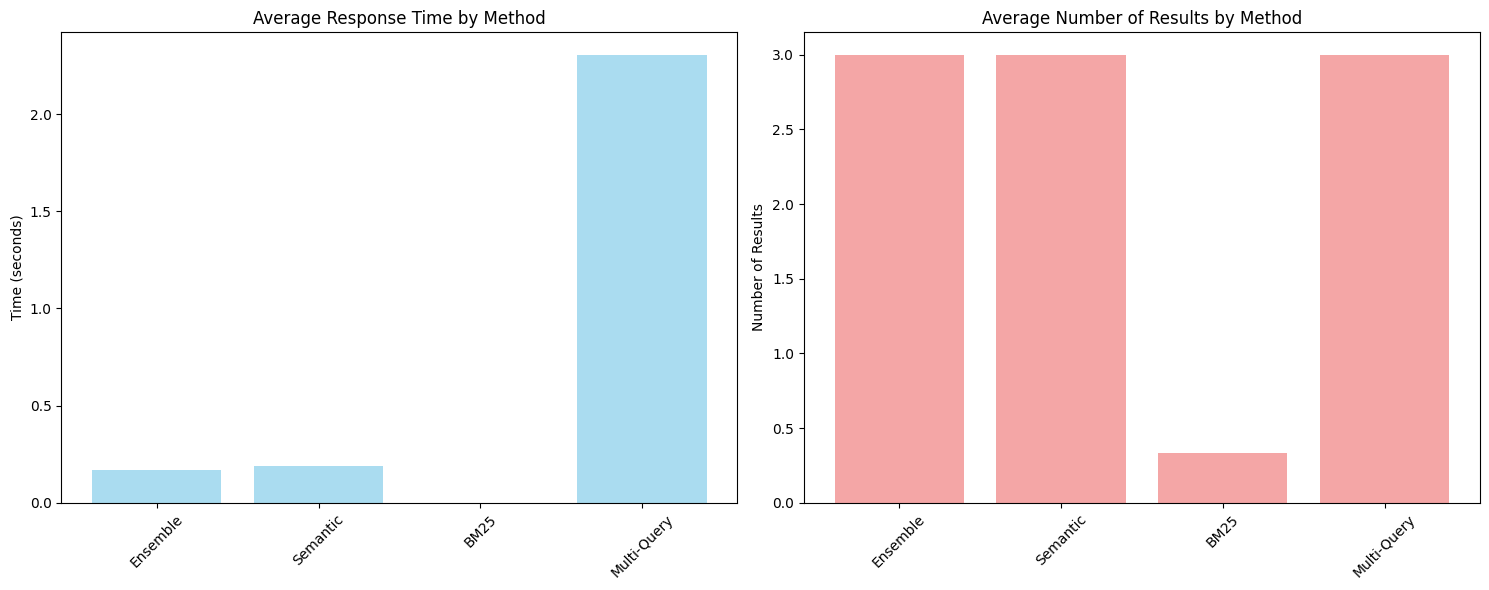


📊 Summary:
   Ensemble: 0.170s | 3.0 results
   Semantic: 0.190s | 3.0 results
   BM25: 0.000s | 0.3 results
   Multi-Query: 2.306s | 3.0 results

✅ Performance comparison complete!


In [6]:
# Cell 6: Performance Comparison and Visualization
def compare_retrieval_methods(queries: List[str], retrievers: Dict[str, Any], top_k: int = 3):
    """
    Compare different retrieval methods on multiple queries.
    """
    print("📊 Performance Comparison")
    
    results = {}
    
    for query in queries:
        query_results = {}
        
        for method_name, retriever in retrievers.items():
            start_time = time.time()
            
            try:
                retriever_results = retriever.retrieve(query, top_k=top_k)
                end_time = time.time()
                
                query_results[method_name] = {
                    'results': retriever_results,
                    'time': end_time - start_time,
                    'num_results': len(retriever_results)
                }
                
            except Exception as e:
                query_results[method_name] = {
                    'results': [],
                    'time': 0,
                    'num_results': 0,
                    'error': str(e)
                }
        
        results[query] = query_results
    
    print(f"   ✅ Tested {len(retrievers)} methods on {len(queries)} queries")
    return results

def visualize_performance(results: Dict[str, Any]):
    """
    Create visualizations for retrieval performance comparison.
    """
    print("\n📈 Creating Visualizations")
    
    # Prepare data for visualization
    methods = []
    avg_times = []
    avg_results = []
    
    # Get all unique methods
    all_methods = set()
    for query_results in results.values():
        all_methods.update(query_results.keys())
    
    # Calculate averages for each method
    for method in all_methods:
        times = []
        result_counts = []
        
        for query_results in results.values():
            if method in query_results and 'error' not in query_results[method]:
                times.append(query_results[method]['time'])
                result_counts.append(query_results[method]['num_results'])
        
        if times:  # Only include methods with successful results
            methods.append(method)
            avg_times.append(np.mean(times))
            avg_results.append(np.mean(result_counts))
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Response time comparison
    ax1.bar(methods, avg_times, color='skyblue', alpha=0.7)
    ax1.set_title('Average Response Time by Method')
    ax1.set_ylabel('Time (seconds)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Number of results comparison
    ax2.bar(methods, avg_results, color='lightcoral', alpha=0.7)
    ax2.set_title('Average Number of Results by Method')
    ax2.set_ylabel('Number of Results')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 Summary:")
    for i, method in enumerate(methods):
        print(f"   {method}: {avg_times[i]:.3f}s | {avg_results[i]:.1f} results")

# Test all retrieval methods
print("🧪 Comprehensive Performance Testing")

# Initialize all retrievers
bm25_retriever = BM25Retriever()
bm25_retriever.fit(prepared_docs)

semantic_retriever = SemanticRetriever(embeddings)
semantic_retriever.fit(prepared_docs)

multi_query_retriever = MultiQueryRetriever(semantic_retriever, llm)

ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, semantic_retriever],
    weights=[0.3, 0.7]
)

# Define retrievers to test
retrievers = {
    'BM25': bm25_retriever,
    'Semantic': semantic_retriever,
    'Multi-Query': multi_query_retriever,
    'Ensemble': ensemble_retriever
}

# Test queries
test_queries = [
    "transformer attention mechanism",
    "neural network architecture",
    "machine learning optimization"
]

# Run comparison
comparison_results = compare_retrieval_methods(test_queries, retrievers, top_k=3)

# Visualize results
visualize_performance(comparison_results)

print("\n✅ Performance comparison complete!")


### Achievements:
- ✅ **BM25 Implementation** - Keyword-based sparse retrieval
- ✅ **Semantic Search** - Dense vector similarity search  
- ✅ **Multi-Query Retrieval** - Multiple search strategies
- ✅ **Ensemble Retrieval** - Combining multiple methods
- ✅ **Performance Comparison** - Method evaluation and visualization
- ✅ **Real API Integration** - ArXiv + Tavily data sources

